In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

import math
import random
import cv2
import numpy as np
import shutil
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow import keras

In [87]:
file_path = './data\\animals\\'
file_names = os.listdir(file_path)
file_names

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat',
 'caterpillar',
 'chimpanzee',
 'cockroach',
 'cow',
 'coyote',
 'crab',
 'crow',
 'deer',
 'dog',
 'dolphin',
 'donkey',
 'dragonfly',
 'duck',
 'eagle',
 'elephant',
 'flamingo',
 'fly',
 'fox',
 'goat',
 'goldfish',
 'goose',
 'gorilla',
 'grasshopper',
 'hamster',
 'hare',
 'hedgehog',
 'hippopotamus',
 'hornbill',
 'horse',
 'hummingbird',
 'hyena',
 'jellyfish',
 'kangaroo',
 'koala',
 'ladybugs',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'mosquito',
 'moth',
 'mouse',
 'octopus',
 'okapi',
 'orangutan',
 'otter',
 'owl',
 'ox',
 'oyster',
 'panda',
 'parrot',
 'pelecaniformes',
 'penguin',
 'pig',
 'pigeon',
 'porcupine',
 'possum',
 'raccoon',
 'rat',
 'reindeer',
 'rhinoceros',
 'sandpiper',
 'seahorse',
 'seal',
 'shark',
 'sheep',
 'snake',
 'sparrow',
 'squid',
 'squirrel',
 'starfish',
 'swan',
 'tiger',
 'turkey',
 'turtle',
 'whale',
 'wolf',
 'wombat',
 'woodpecker',


In [88]:
for name in file_names:
    j = 1
    src = os.path.join(file_path, name)
    src1 = os.listdir(src)
    for name1 in src1:
        dst = f'{name}_{j}.jpg'
        os.rename(src + '\\' + name1, src + '\\' + dst)
        j += 1

In [89]:
df = pd.DataFrame(columns = ['name', 'species'])
i = 1
for name in file_names:
    src = os.path.join(file_path, name)
    src1 = os.listdir(src)
    for name1 in src1:
        elem = {
            'name' : name1.split('.')[0],
            'species' : i
            }
        df.loc[len(df)] = elem
    i += 1
        
df


,name,species
0,antelope_1,1
1,antelope_10,1
2,antelope_11,1
3,antelope_12,1
4,antelope_13,1
...,...,...
5395,zebra_6,90
5396,zebra_60,90
5397,zebra_7,90
5398,zebra_8,90


In [90]:
for name in file_names:
    src = os.path.join(file_path, name)
    src1 = os.listdir(src)
    for name1 in src1:
        shutil.move(src + '\\' + name1, file_path)

In [2]:
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [3]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            name = r['name']
            
            image = cv2.imread(f'data/animals/{name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')
            image = image / 255.
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [4]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import activations

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state = 42)

df['fold'] = -1
for idx, (t,v) in enumerate(kf.split(df), 1):
    print(t,v, len(v))
    df.loc[v, 'fold'] = idx

In [112]:
df.to_csv('./data/animal.csv', index= False)

In [5]:
csv_path = 'data/animal.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

In [6]:
f = open('./data/name of the animals.txt', 'r')
namess = np.loadtxt(f,dtype='str')
namess

array(['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison',
       'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee',
       'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog',
       'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant',
       'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla',
       'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus',
       'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish',
       'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard',
       'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi',
       'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot',
       'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine',
       'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper',
       'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid',
       'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle',
       'whale', 'wolf', 'wombat'

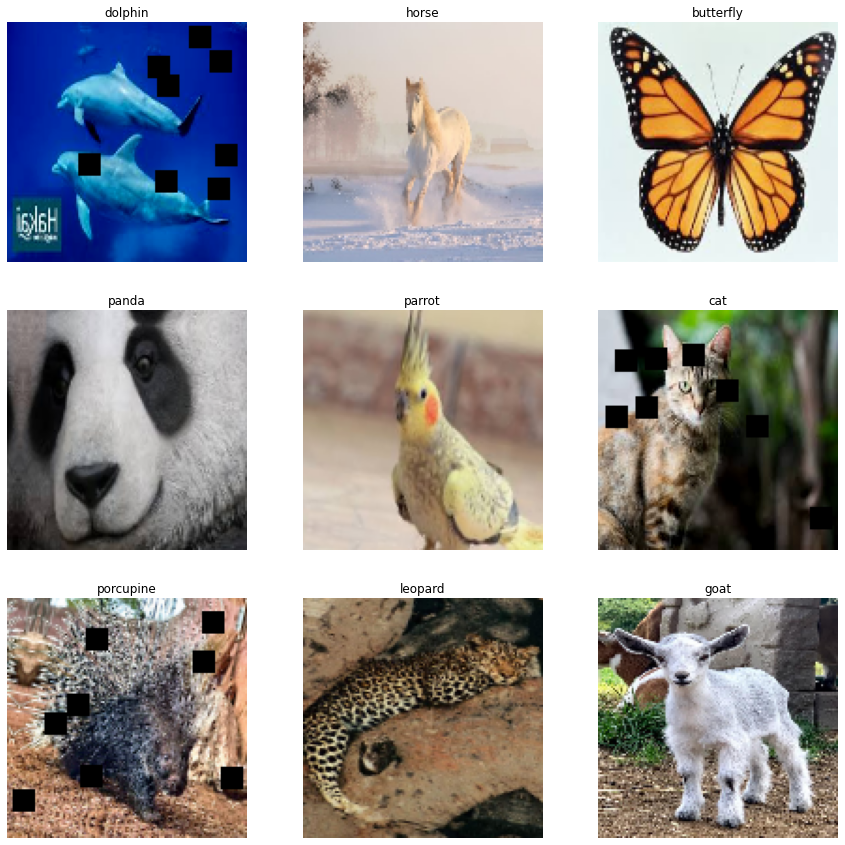

In [7]:
class_names = namess

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(class_names[y[i]])
        plt.axis('off')
    break


In [8]:
from tensorflow.keras import optimizers

def get_model(input_shape):
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape = input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    
    x = base_model(inputs)
    output = layers.Dense(90, activation='softmax')(x)
    model = keras.Model(inputs, output)
    
    return model


input_shape = (128,128, 3)
model = get_model(input_shape)

adam = keras.optimizers.Adam(lr = 0.0001)
model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy',
    metrics = 'accuracy'
)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 90)                115290    
                                                                 
Total params: 4,164,861
Trainable params: 4,122,838
Non-trainable params: 42,023
_________________________________________________________________


C:\Users\khj_a\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
34/34 [==============================] - 368s 11s/step - loss: 2.4731 - accuracy: 0.5208 - val_loss: 4.5093 - val_accuracy: 0.0083
Epoch 2/10
34/34 [==============================] - 365s 11s/step - loss: 1.9775 - accuracy: 0.6181 - val_loss: 4.5035 - val_accuracy: 0.0139
Epoch 3/10
34/34 [==============================] - 356s 10s/step - loss: 1.5656 - accuracy: 0.6884 - val_loss: 4.5038 - val_accuracy: 0.0185
Epoch 4/10
34/34 [==============================] - 356s 10s/step - loss: 1.2658 - accuracy: 0.7523 - val_loss: 4.5108 - val_accuracy: 0.0213
Epoch 5/10
34/34 [==============================] - 353s 10s/step - loss: 1.0356 - accuracy: 0.7870 - val_loss: 4.5215 - val_accuracy: 0.0204
Epoch 6/10
34/34 [==============================] - 299s 9s/step - loss: 0.8523 - accuracy: 0.8266 - val_loss: 4.5240 - val_accuracy: 0.0176
Epoch 7/10
34/34 [==============================] - 292s 9s/step - loss: 0.7241 - accuracy: 0.8472 - val_loss: 4.5350 - val_accuracy: 0.0185
Epoch 8/

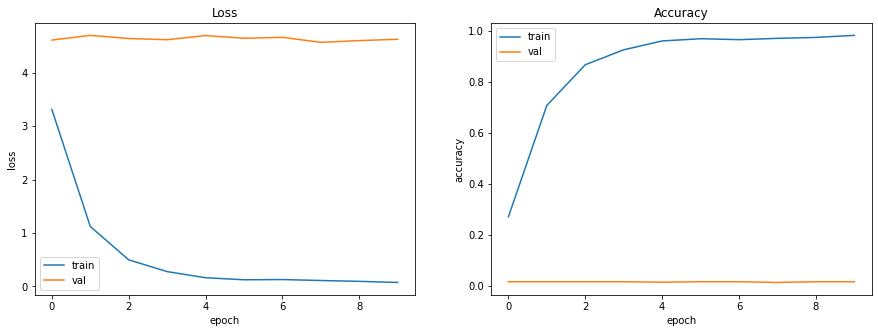

In [10]:
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()